In [160]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import time
import pandas as pd
import os
import shapely 

from shapely.geometry import Point, Polygon, LineString, MultiLineString, MultiPolygon
from shapely import affinity
from shapely.ops import split, snap, linemerge
from itertools import combinations
from random import randint

In [190]:
cdir = os.getcwd() 
path = os.path.dirname(cdir) + "/geojson_polygons"

glasgow = gpd.read_file(f"{path}/glasgow.geojson")#.to_crs(3857)#.buffer(3000,join_style=2).to_crs(4326))
glasgow_pd = gpd.read_file(f"{path}/glasgow_polling_districts.geojson")

print(glasgow.area)

0    0.025301
dtype: float64


/tmp/ipykernel_9158/2692964593.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(glasgow.area)


In [3]:
# features_from_bbox takes bbox as [north, south, east, west]
# so a reorder of total_bounds is needed (it goes minx, miny, maxx, maxy)
bb = glasgow.total_bounds
bb[0], bb[1], bb[2], bb[3] = bb[3], bb[1], bb[2], bb[0] 

tags = {"highway" : True}
#tags = {"highway" : True, "railway" : True, "waterway" : True}
ways = ox.features_from_bbox(bbox=bb, tags=tags)
ways = ways.loc[ways.geometry.type=='LineString']
ways = ways.loc[ways.highway!="footway"]
ways_clip = gpd.clip(ways, glasgow)

/tmp/ipykernel_9158/1107372128.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(glasgow.area)


0    0.025301
dtype: float64


KeyboardInterrupt: 

<Axes: >

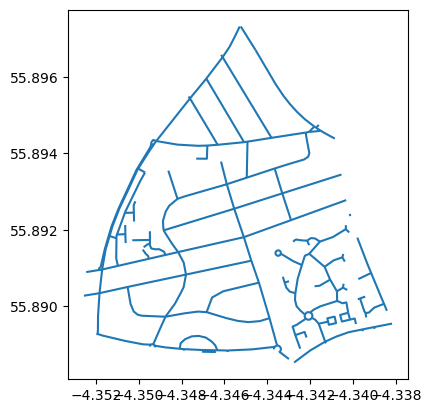

In [9]:
glasgow_pd = gpd.read_file(f"{path}/glasgow_polling_districts.geojson")
glasgow_pd_networks = [gpd.clip(ways, geom) for geom in glasgow_pd.geometry]

<function matplotlib.pyplot.show(close=None, block=None)>

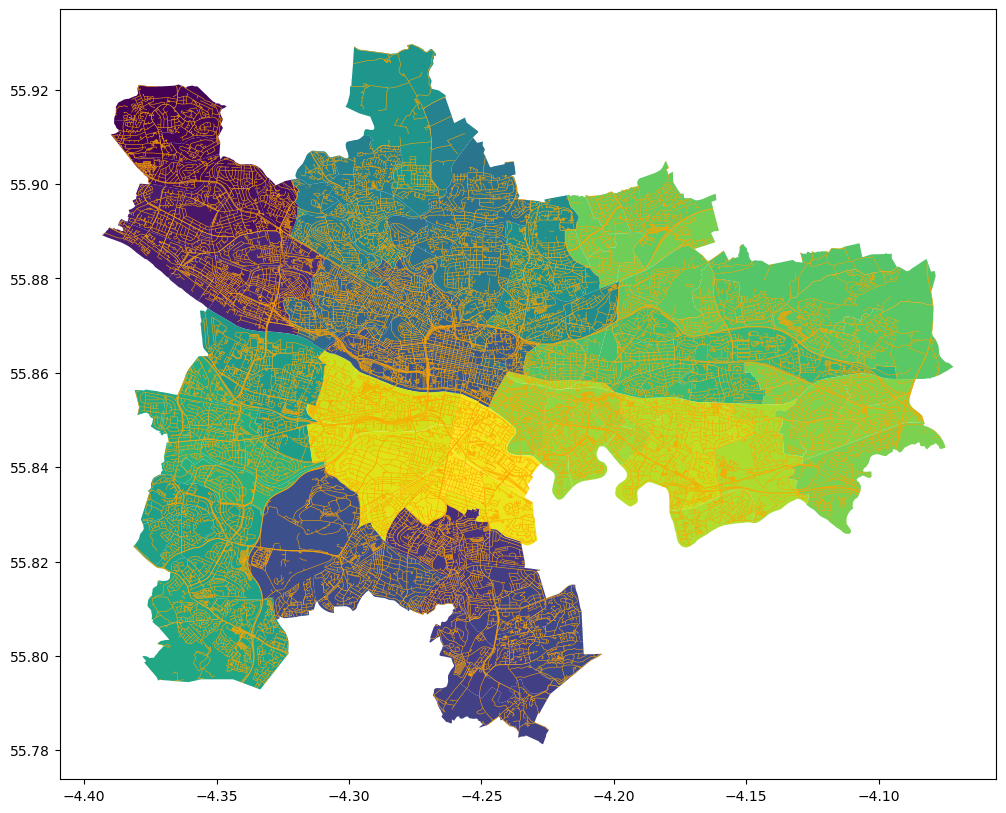

In [15]:
fig, ax = plt.subplots(1,1,figsize=(15,10))

ways_clip.plot(ax=ax, linewidth=0.4, edgecolor='orange')
glasgow_pd.plot(ax=ax, column='POLLING_DISTRICT', cmap='viridis')#facecolor='none', edgecolor='orange')
plt.show


<Axes: >

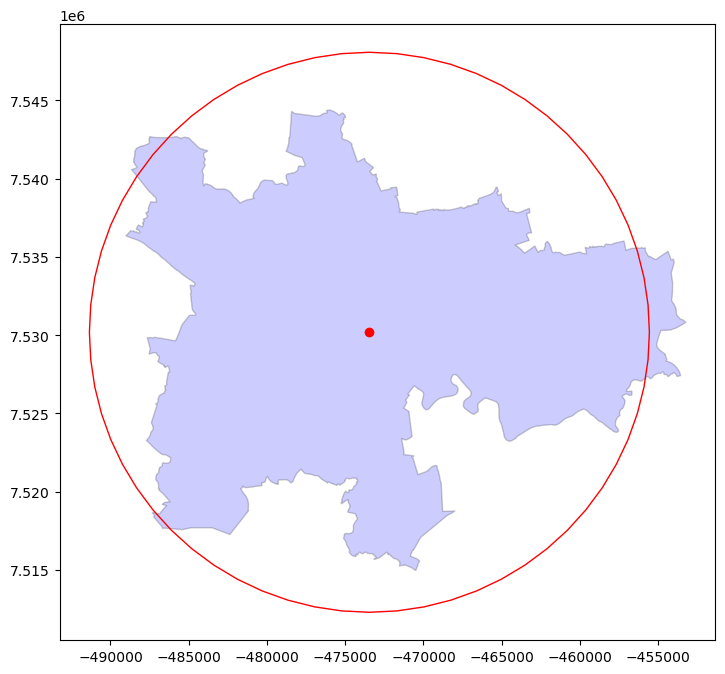

In [6]:
glasgow = glasgow.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10,8))
glasgow.plot(ax=ax, edgecolor='black', facecolor='blue', alpha=0.2)
glasgow.centroid.plot(ax=ax, color='red')

glasgow_w = glasgow.bounds.maxx[0] - glasgow.bounds.minx[0]

glasgow_buffer = glasgow.centroid.buffer(glasgow_w/2)

glasgow_buffer.plot(ax=ax, edgecolor='red', facecolor='none')

In [82]:
def n_buffer(n, poly):
    poly_r = (poly.bounds.maxx[0] - poly.bounds.minx[0])/2
    poly_c = (poly.centroid.x[0], poly.centroid.y[0])
    a = Point([poly.centroid.x, poly.centroid.y+poly_r])
    vertices = [a]
    for i in range(n):
        vertices.append(affinity.rotate(a, (360/n)*(i+1), origin=poly_c))
    print("vertices:", vertices)
    return gpd.GeoSeries(Polygon(vertices))

def n_buffer_lines(n, poly, rot=0):
    poly_r = (poly.bounds.maxx[0] - poly.bounds.minx[0]) * 0.75
    poly_c = (poly.centroid.x[0], poly.centroid.y[0])
    a = affinity.rotate(Point([poly.centroid.x, poly.centroid.y+poly_r]), rot, origin=poly_c)
    lines = [LineString([poly_c,[a.x, a.y]])]
    for i in range(n):
        vert_rotate = affinity.rotate(a, (360/n)*(i+1), origin=poly_c)
        lines.append(LineString([poly_c, [vert_rotate.x, vert_rotate.y]]))
    print("lines:", lines)
    return gpd.GeoSeries(lines)

def n_radial(n, poly, rot=0):
    poly_r = (poly.bounds.maxx[0] - poly.bounds.minx[0])/2
    poly_c = (poly.centroid.x[0], poly.centroid.y[0])
    buffer = poly.centroid.buffer(poly_r/2)
    a = affinity.rotate(Point([poly.centroid.x, poly.centroid.y+(poly_r*1.2)]), rot, origin=poly_c)
    lines = [LineString([poly_c,[a.x, a.y]])]
    vertices = [a]
    for i in range(n):
        vert_rotate = affinity.rotate(a, (360/n)*(i+1), origin=poly_c)
        vertices.append(vert_rotate)
        lines.append(LineString([poly_c, [vert_rotate.x, vert_rotate.y]]))

    return gpd.GeoDataFrame({'geometry' : lines}, geometry='geometry', crs=3857)

glasgow_r = (glasgow.bounds.maxx[0] - glasgow.bounds.minx[0])/2
glasgow_c = (glasgow.centroid.x[0], glasgow.centroid.y[0])
c = Point([glasgow.centroid.x, glasgow.centroid.y+glasgow_r])

#line = gpd.GeoDataFrame(geometry=gpd.GeoSeries(n_radial(7, glasgow, 10), crs=3857))
line = n_radial(7, glasgow, 10)

buff = glasgow.centroid.buffer(glasgow_r)[0]

buff_list = [glasgow.centroid.buffer(glasgow_r * (1 - i*0.25))[0] for i in range(4)]

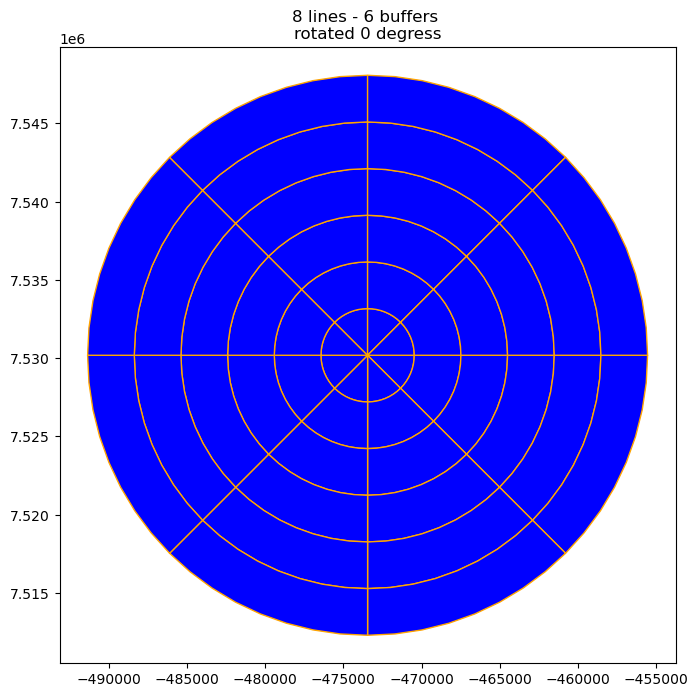

In [231]:
def find_overlaps(gdf):
    """Returns a list of tuples identifying the geometries
    that overlap one another.
    """
    overlaps, retouch = [], {}
    for x, y in combinations(gdf.index.tolist(), 2):
        g_x = gdf.loc[x].geometry
        g_y = gdf.loc[y].geometry
        if g_x.intersects(g_y):
            overlaps.append([x, y])

    for t, b in overlaps:
        retouch.setdefault(t, []).append(b)

    return overlaps, retouch


def clip_overlaps_by_weight(gdf, col, tol=0.0000001):
    """Clips out overlapping geometries within a shapefile
    ranked by an attribute.
    """

    gdf.sort_values(by=col, axis=0, ascending=False, inplace=True)
    gdf.reset_index(drop=True,inplace=True)
    dupd = gdf.geometry.duplicated()
    if dupd.any():  # keep highest weighted duplicate, remove the rest
        gdf = gdf.loc[~dupd]

    overlaps, retouch = find_overlaps(gdf)

    for overlap in overlaps:
        top, bot = gdf.loc[overlap].geometry
        try:
            bot = bot.difference(top)
        except:
            breakpoint()
        top = snap(top, bot, tol)
        gdf.loc[overlap, "geometry"] = gpd.GeoSeries([top, bot], index=overlap)

    for clipper, clip_list in retouch.items():
        for clipped in clip_list[:-1]:
            top, bot = gdf.loc[[clipper, clipped]].geometry
            gdf.loc[clipped, "geometry"] = snap(bot, top, tol)

    return gdf.reset_index(drop=True)

def n_radial(n, poly, rot=0):
    poly_r = (poly.bounds.maxx[0] - poly.bounds.minx[0])/2
    poly_c = (poly.centroid.x[0], poly.centroid.y[0])
    buffer = poly.centroid.buffer(poly_r/2)
    a = affinity.rotate(Point([poly.centroid.x, poly.centroid.y+(poly_r)]), rot, origin=poly_c) #poly_r*1.2
    lines = [LineString([poly_c,[a.x, a.y]])]
    vertices = [a]
    for i in range(n):
        vert_rotate = affinity.rotate(a, (360/n)*(i+1), origin=poly_c)
        vertices.append(vert_rotate)
        lines.append(LineString([poly_c, [vert_rotate.x, vert_rotate.y]]))

    return gpd.GeoDataFrame({'geometry' : lines}, geometry='geometry', crs=3857)

def radial_split(polygon, n=5, rot=0, buffers=4):
    # calculate centre and radius of input polygon
    polygon_r = (polygon.bounds.maxx[0] - polygon.bounds.minx[0])/2

    # generate buffers and remove overlapping areas
    buff_list = [polygon.centroid.buffer(polygon_r * (1 - i*(1/buffers)))[0] for i in range(buffers)]
    cut_buffers = clip_overlaps_by_weight(gpd.GeoDataFrame({'id': [x for x in range(len(buff_list))], 'geometry' : buff_list}, geometry='geometry'), 'id')
    
    # generate n radial lines and merge them into one single LineString   
    lines = n_radial(n, polygon, rot)
    points = [[point for point in line.coords] for line in lines.geometry[:]]
    merge_line = LineString([val for sublist in points for val in sublist])

    # divide the buffers using the radial linestring and return
    ring_split = [MultiPolygon(split(cut_buffers.geometry[i], merge_line)) for i in range(buffers)]
    # returns the split buffers AND the uncut buffers
    return gpd.GeoDataFrame(geometry=gpd.GeoSeries([poly for poly in ring_split])), gpd.GeoDataFrame({'geometry':buff_list}, geometry='geometry', crs=3857)

glasgow = glasgow.to_crs(3857)
glasgow_pd = glasgow_pd.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10,8))
glasgow_radial = radial_split(glasgow)

n = 8
rot = 0
buffers = 6

glasgow_radial, glasgow_buffers = radial_split(glasgow, n, rot, buffers)

glasgow_inner = glasgow_buffers.iloc[[-1]]
#inner_pds = glasgow_pd.sjoin(glasgow_inner)
glasgow.centroid.plot(ax=ax, color='green')

ax.set_title(f"{n} lines - {buffers} buffers \nrotated {rot} degress")
glasgow_radial.plot(ax=ax, edgecolor='orange', facecolor='blue')

plt.show()

multi_list [<MULTIPOLYGON (((-468980.922 7530182.609, -468980.922 7530182.609, -473454.3...>, <MULTIPOLYGON (((-464550.578 7529305.664, -464679.408 7528437.165, -464892.7...>, <MULTIPOLYGON (((-460291.938 7527564.443, -460505.237 7526712.906, -464821.6...>, <MULTIPOLYGON (((-456331.143 7524988.342, -456922.723 7523334.986, -457673.5...>]


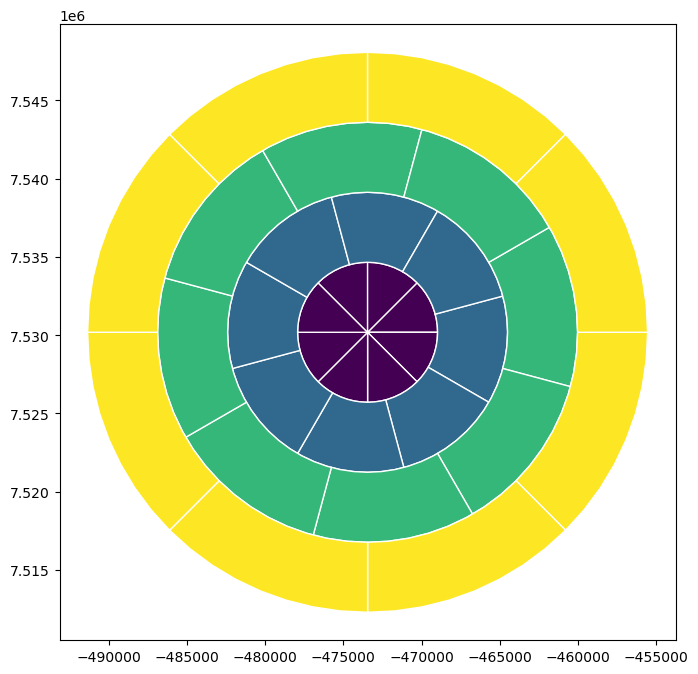

In [388]:
def n_radial(n, poly, rot=0):
    poly_r = (poly.bounds.maxx[0] - poly.bounds.minx[0])/2
    poly_c = (poly.centroid.x[0], poly.centroid.y[0])
    a = affinity.rotate(Point([poly.centroid.x, poly.centroid.y+(poly_r*1.2)]), rot, origin=poly_c) #poly_r*1.2
    lines = [LineString([poly_c,[a.x, a.y]])]
    vertices = [a]
    for i in range(n):
        vert_rotate = affinity.rotate(a, (360/n)*(i+1), origin=poly_c)
        vertices.append(vert_rotate)
        lines.append(LineString([poly_c, [vert_rotate.x, vert_rotate.y]]))

    return gpd.GeoDataFrame({'geometry' : lines}, geometry='geometry', crs=3857)

def radial_split(polygon, n=5, rot=0, buffers=4):
    # calculate centre and radius of input polygon
    polygon_r = (polygon.bounds.maxx[0] - polygon.bounds.minx[0])/2

    # generate buffers and remove overlapping areas
    buff_list = [polygon.centroid.buffer(polygon_r * (1 - i*(1/buffers)))[0] for i in range(buffers)]
    cut_buffers = clip_overlaps_by_weight(gpd.GeoDataFrame({'id': [x for x in range(len(buff_list))], 'geometry' : buff_list}, geometry='geometry'), 'id')
    
    ### if i want to offset the rotations, the buffers will stay the same, will need a set of lines for each buffer on it's own

    # generate n radial lines and merge them into one single LineString   


    polygon_temp = gpd.GeoDataFrame(geometry=gpd.GeoSeries(buff_list))
    multi_list = []
    for index in range(len(polygon_temp)):
        current = cut_buffers.iloc[[index]].reset_index(drop=True)
        lines = n_radial(n, current, 60*index)
        points = [[point for point in line.coords] for line in lines.geometry[:]]
        merge_line = LineString([val for sublist in points for val in sublist])
        # divide the buffers using the radial linestring and return
        ring_split = split(current.geometry[0], merge_line)
        multi_list.append(MultiPolygon(ring_split))
    # returns the split buffers AND the uncut buffers
    print("multi_list", multi_list)
    return gpd.GeoDataFrame(geometry=gpd.GeoSeries([multipoly for multipoly in multi_list])), gpd.GeoDataFrame({'geometry':buff_list}, geometry='geometry', crs=3857)

glasgow = glasgow.to_crs(3857)
glasgow_pd = glasgow_pd.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10,8))

n = 8
rot = 0
buffers = 4

glasgow_radial, glasgow_buffers = radial_split(glasgow, n, rot, buffers)

glasgow_inner = glasgow_buffers.iloc[[-1]]
#inner_pds = glasgow_pd.sjoin(glasgow_inner)
#glasgow.centroid.plot(ax=ax, color='green')

glasgow_radial.reset_index().plot(ax=ax, column='index', edgecolor='white', cmap='viridis')

plt.show()